In [1]:
%reload_ext autoreload
%autoreload 2

import pickle

from utils.utils import split_csv

from preprocessing.cleaning import get_cleaned_data
from preprocessing.encoding import encode_data

from exploration.data_correlations import plot_correlations
from exploration.data_statistics import plot_labels_pie_chart, plot_blood_draw_statistics
from exploration.feature_selection_plots import plot_mrmr_and_rf
from exploration.midterm_exploration import plot_feature_against_diagnosis

from modeling.mrmr_feature_selection import plot_cutoffs
from modeling.logistic import run_logistic_regression, evaluate_logistic_regression
from modeling.RandomForest import run_random_forest, evaluate_random_forest
from modeling.mlp import run_mlp, evaluate_mlp
from modeling.comparisons import plot_f1_scores, plot_mci_f1_scores, plot_average_confusion_matrix

## Constant for output locations

In [2]:
DATAFRAMES = "output/dataframes"
LOGS = "output/logs"
MODELS = "output/models"
PLOTS = "output/plots"

## Constants for the label

In [3]:
LABEL = "P1_PT_TYPE"
AD = 1
CN = 2
MCI = 4

## Clean, encode, and partition the data into blood, clinical, and combined dataframes

In [4]:
df = encode_data(get_cleaned_data())
combined, blood_only, clinical_only_mci = split_csv(df)
clinical_only = clinical_only_mci[clinical_only_mci[LABEL] != MCI]

## Plot some initial exploratory visualizations

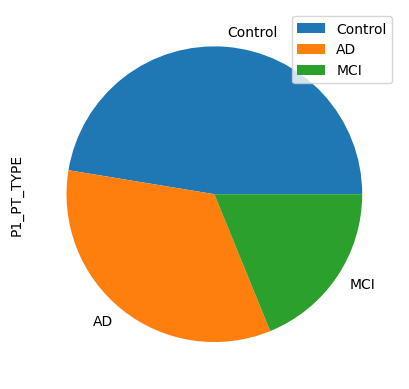

In [5]:
plot_labels_pie_chart(df, png=f"{PLOTS}/Diagnosis Pie Chart.png")

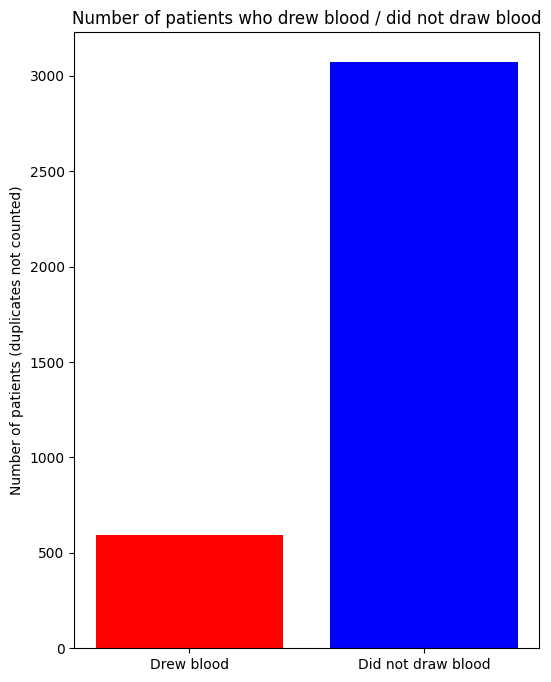

In [6]:
plot_blood_draw_statistics(df, png=f"{PLOTS}/Blood Draw Statistics.png")

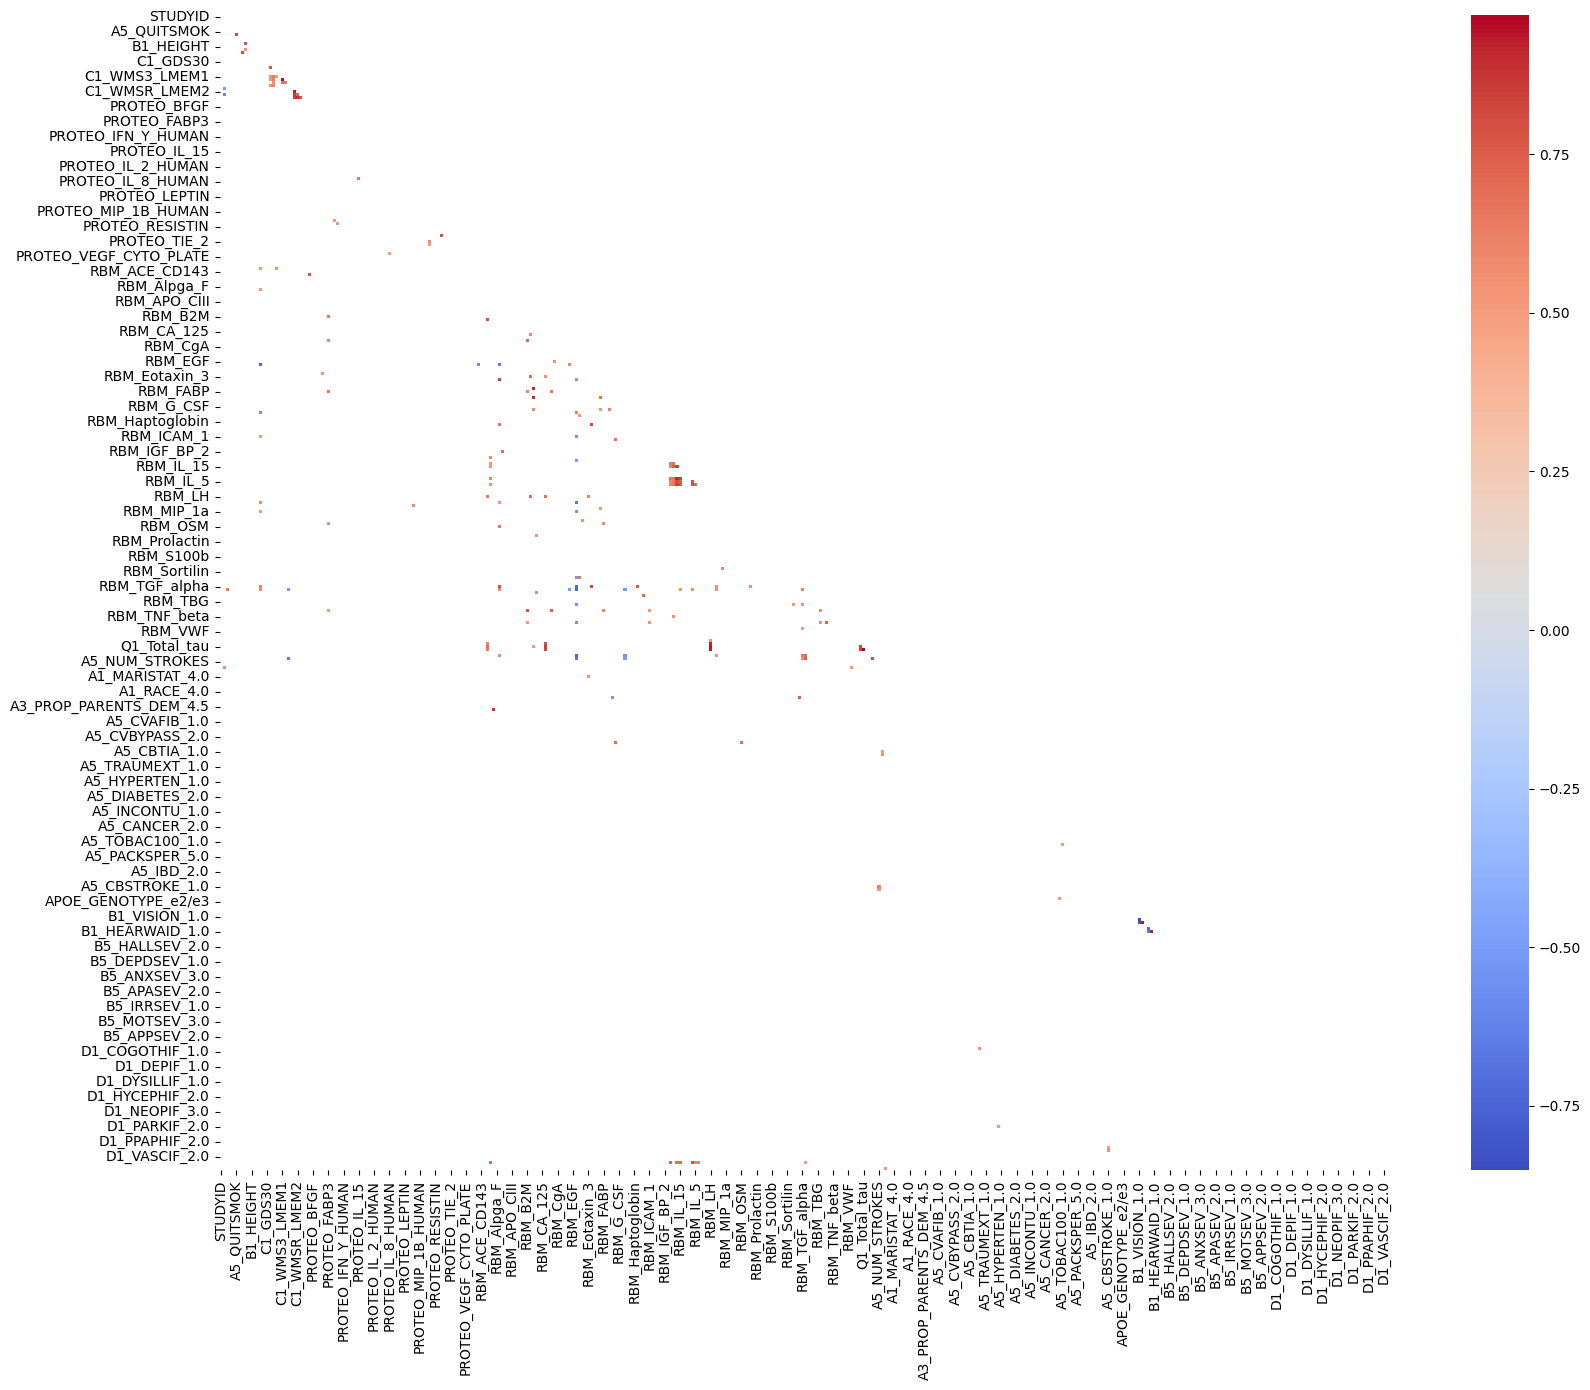

In [7]:
plot_correlations(df)

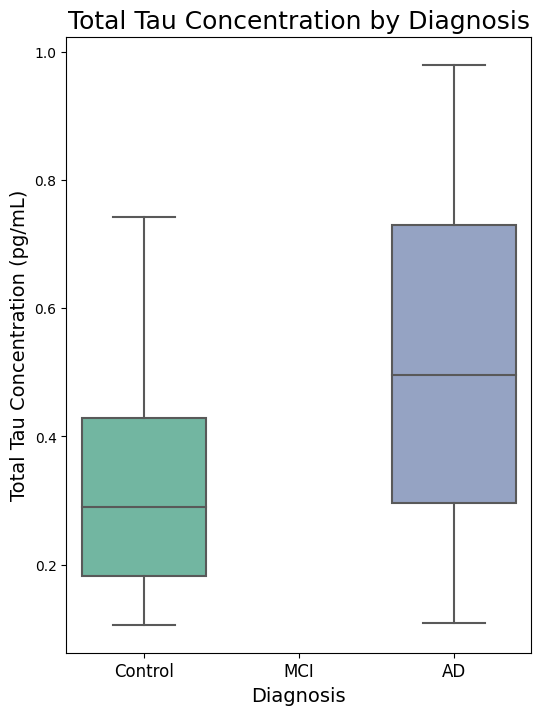

In [8]:
plot_feature_against_diagnosis(
    blood_only,
    "Q1_Total_tau",
    title="Total Tau Concentration by Diagnosis",
    ylabel="Total Tau Concentration (pg/mL)",
    png=f"{PLOTS}/Total Tau Concentration by Diagnosis.png"
)

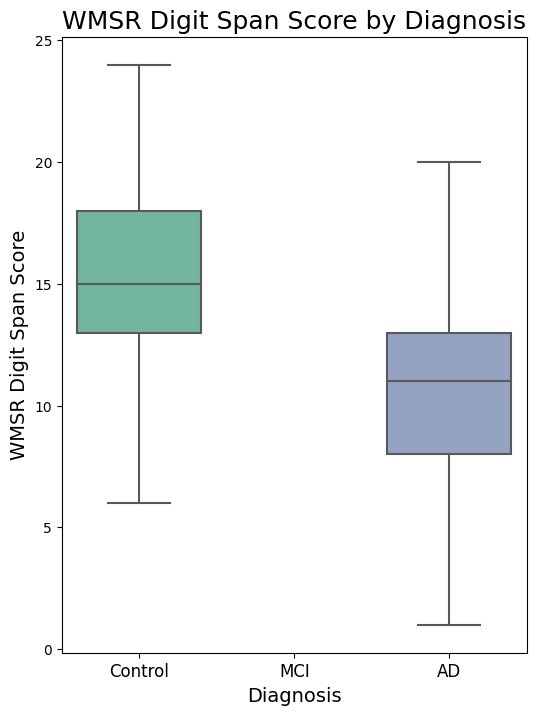

In [9]:
plot_feature_against_diagnosis(
    clinical_only,
    "C1_WMSR_DIGTOT",
    title="WMSR Digit Span Score by Diagnosis",
    ylabel="WMSR Digit Span Score",
    png=f"{PLOTS}/WMSR Digit Span Score by Diagnosis.png"
)

## Run MRMR feature selection to pick features for each of the partitions

100%|██████████| 327/327 [00:05<00:00, 57.45it/s] 


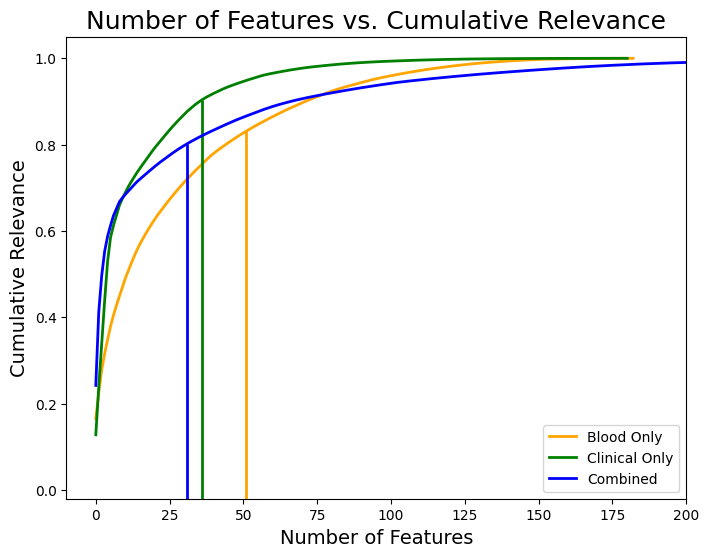

In [10]:
mrmr_output = plot_cutoffs(
    blood_only,
    clinical_only,
    combined,
    title="Number of Features vs. Cumulative Relevance",
    xlabel="Number of Features",
    ylabel="Cumulative Relevance",
    png=f"{PLOTS}/MRMR Curves"
)

blood_features = mrmr_output["blood"]["features"]
clinical_features = mrmr_output["clinical"]["features"]
combined_features = mrmr_output["combined"]["features"]

blood_mrmr_scores = mrmr_output["blood"]["relevances"]
clinical_mrmr_scores = mrmr_output["clinical"]["relevances"]
combined_mrmr_scores = mrmr_output["combined"]["relevances"]

blood_only_subset = blood_only[blood_features + [LABEL]]
clinical_only_subset = clinical_only[clinical_features + [LABEL]]
combined_subset = combined[combined_features + [LABEL]]
clinical_only_subset_mci = clinical_only_mci[clinical_features + [LABEL]]

## Run logistic regression on the entire feature set

In [11]:
blood_lr_model = run_logistic_regression(blood_only, num_iters=20, pkl=f"{MODELS}/Blood Only LR.pkl")

In [12]:
blood_lr = evaluate_logistic_regression(f"{MODELS}/Blood Only LR.pkl")

Average micro-F1 score: 0.828151260504202
Average confusion matrix:
[[49.65 11.3 ]
 [ 9.15 48.9 ]]


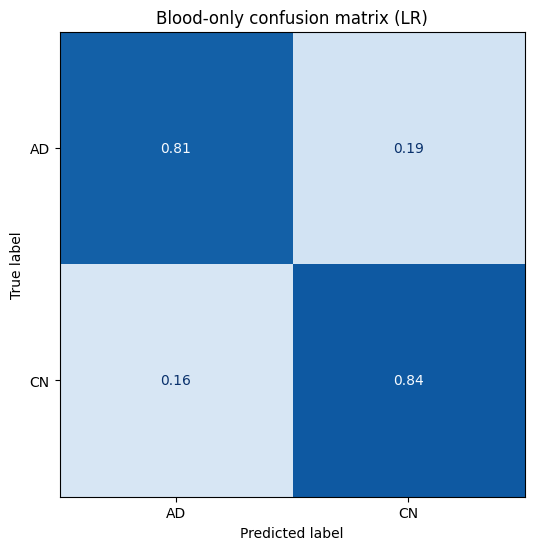

In [13]:
plot_average_confusion_matrix(
    blood_lr["confusion"],
    ["AD", "CN"],
    "Blood-only confusion matrix (LR)",
    png=f"{PLOTS}/Blood-only confusion matrix (LR)"
)

In [14]:
clinical_lr_model = run_logistic_regression(clinical_only, num_iters=20, pkl=f"{MODELS}/Clinical Only LR.pkl")

In [15]:
clinical_lr = evaluate_logistic_regression(f"{MODELS}/Clinical Only LR.pkl")

Average micro-F1 score: 0.9709608843537414
Average confusion matrix:
[[ 935.9    41.85]
 [  26.45 1347.8 ]]


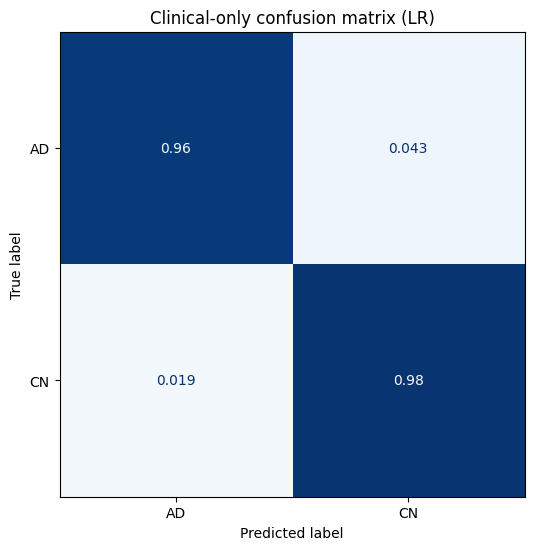

In [16]:
plot_average_confusion_matrix(
    clinical_lr["confusion"],
    ["AD", "CN"],
    "Clinical-only confusion matrix (LR)",
    png=f"{PLOTS}/Clinical-only confusion matrix (LR)"
)

In [17]:
combined_lr_model = run_logistic_regression(combined, num_iters=20, pkl=f"{MODELS}/Combined LR.pkl")

In [18]:
combined_lr = evaluate_logistic_regression(f"{MODELS}/Combined LR.pkl")

Average micro-F1 score: 0.9441176470588235
Average confusion matrix:
[[57.4   3.55]
 [ 3.1  54.95]]


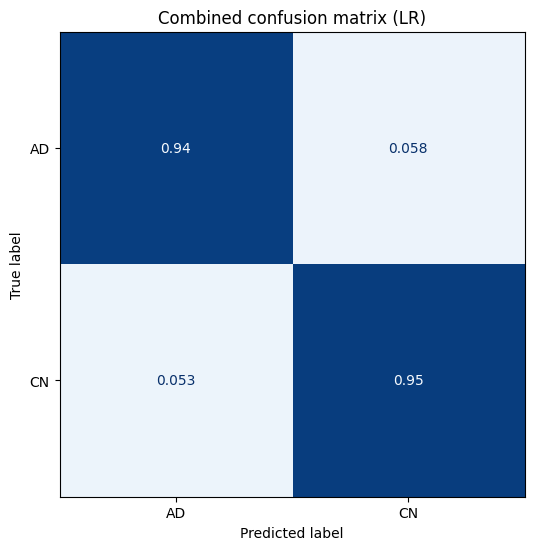

In [19]:
plot_average_confusion_matrix(
    combined_lr["confusion"],
    ["AD", "CN"],
    "Combined confusion matrix (LR)",
    png=f"{PLOTS}/Combined confusion matrix (LR)"
)

## Run logistic regression on the features selected by MRMR

In [20]:
blood_lr_mrmr_model = run_logistic_regression(blood_only_subset, num_iters=20, pkl=f"{MODELS}/Blood Only LR with MRMR.pkl")

In [21]:
blood_lr_mrmr = evaluate_logistic_regression(f"{MODELS}/Blood Only LR with MRMR.pkl")

Average micro-F1 score: 0.8260504201680675
Average confusion matrix:
[[49.15 11.8 ]
 [ 8.9  49.15]]


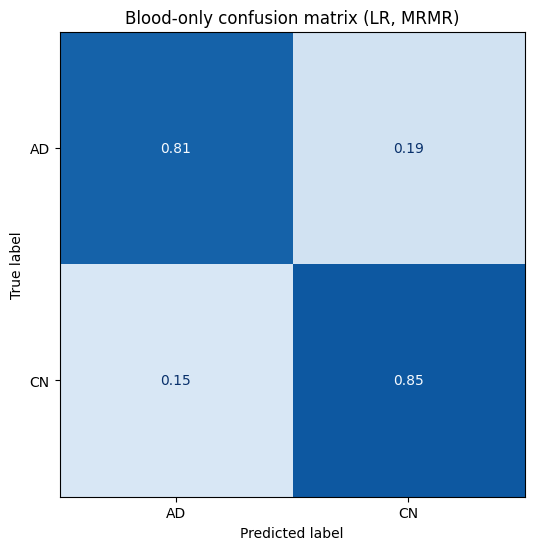

In [22]:
plot_average_confusion_matrix(
    blood_lr_mrmr["confusion"],
    ["AD", "CN"],
    "Blood-only confusion matrix (LR, MRMR)",
    png=f"{PLOTS}/Blood-only confusion matrix (LR, MRMR)"
)

In [23]:
clinical_lr_mrmr_model = run_logistic_regression(clinical_only_subset, num_iters=20, pkl=f"{MODELS}/Clinical Only LR with MRMR.pkl")

In [24]:
clinical_lr_mrmr = evaluate_logistic_regression(f"{MODELS}/Clinical Only LR with MRMR.pkl")

Average micro-F1 score: 0.9594175170068026
Average confusion matrix:
[[ 910.55   67.2 ]
 [  28.25 1346.  ]]


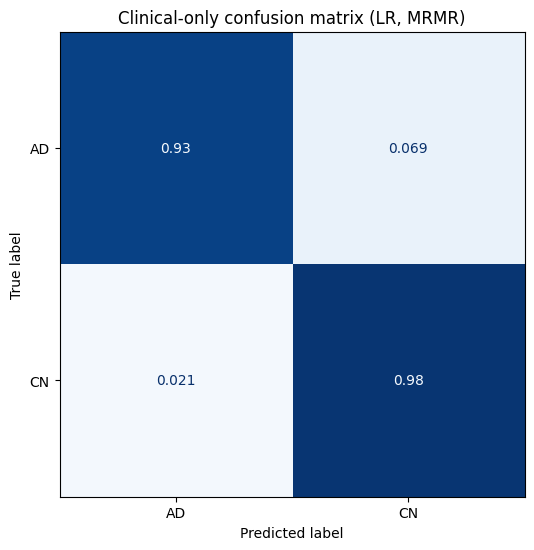

In [25]:
plot_average_confusion_matrix(
    clinical_lr_mrmr["confusion"],
    ["AD", "CN"],
    "Clinical-only confusion matrix (LR, MRMR)",
    png=f"{PLOTS}/Clinical-only confusion matrix (LR, MRMR)"
)

In [26]:
combined_lr_mrmr_model = run_logistic_regression(combined_subset, num_iters=20, pkl=f"{MODELS}/Combined LR with MRMR.pkl")

In [27]:
combined_lr_mrmr = evaluate_logistic_regression(f"{MODELS}/Combined LR with MRMR.pkl")

Average micro-F1 score: 0.9378151260504202
Average confusion matrix:
[[57.45  3.5 ]
 [ 3.9  54.15]]


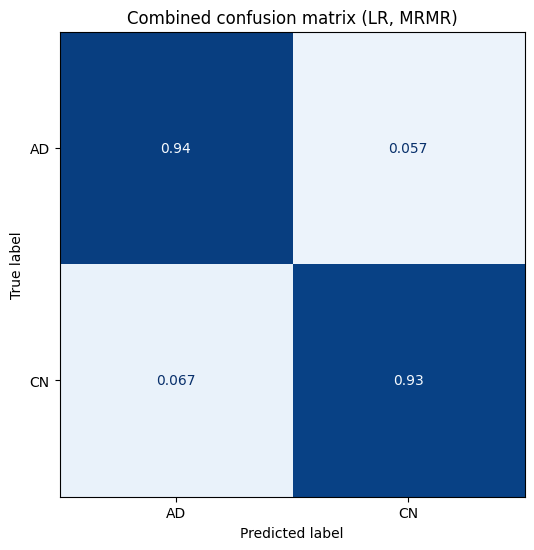

In [28]:
plot_average_confusion_matrix(
    combined_lr_mrmr["confusion"],
    ["AD", "CN"],
    "Combined confusion matrix (LR, MRMR)",
    png=f"{PLOTS}/Combined confusion matrix (LR, MRMR)"
)

## Run random forest

In [29]:
blood_rf_model = run_random_forest(blood_only, num_iters=20, pkl=f"{MODELS}/Blood Only RF.pkl")

In [30]:
blood_rf = evaluate_random_forest(f"{MODELS}/Blood Only RF.pkl")

Average micro-F1 score: 0.820588235294118
Average confusion matrix:
[[49.8  10.  ]
 [11.35 47.85]]


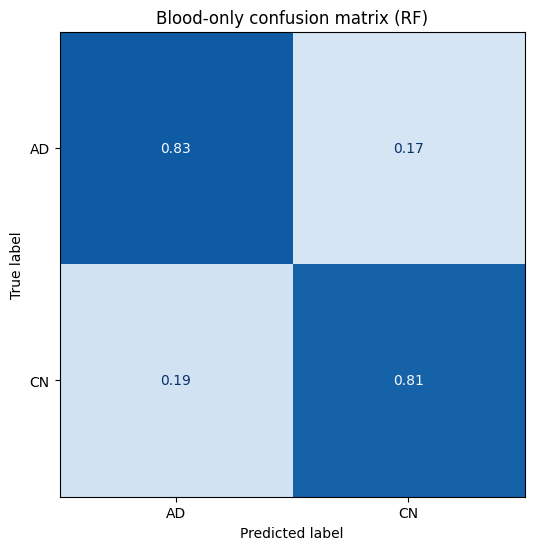

In [31]:
plot_average_confusion_matrix(
    blood_rf["confusion"],
    ["AD", "CN"],
    "Blood-only confusion matrix (RF)",
    png=f"{PLOTS}/Blood-only confusion matrix (RF)"
)

In [32]:
clinical_rf_model = run_random_forest(clinical_only, num_iters=20, pkl=f"{MODELS}/Clinical Only RF.pkl")

In [33]:
clinical_rf = evaluate_random_forest(f"{MODELS}/Clinical Only RF.pkl")

Average micro-F1 score: 0.9789753401360546
Average confusion matrix:
[[ 951.4    28.7 ]
 [  20.75 1351.15]]


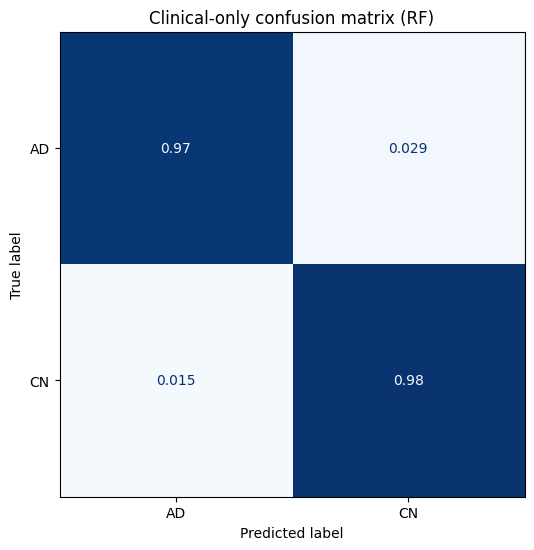

In [34]:
plot_average_confusion_matrix(
    clinical_rf["confusion"],
    ["AD", "CN"],
    "Clinical-only confusion matrix (RF)",
    png=f"{PLOTS}/Clinical-only confusion matrix (RF)"
)

In [35]:
combined_rf_model = run_random_forest(combined, num_iters=20, pkl=f"{MODELS}/Combined RF.pkl")

In [36]:
combined_rf = evaluate_random_forest(f"{MODELS}/Combined RF.pkl")

Average micro-F1 score: 0.9609243697478991
Average confusion matrix:
[[57.2   2.6 ]
 [ 2.05 57.15]]


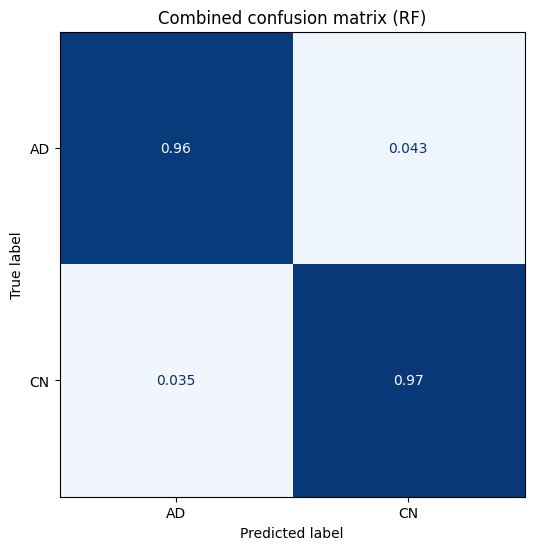

In [37]:
plot_average_confusion_matrix(
    combined_rf["confusion"],
    ["AD", "CN"],
    "Combined confusion matrix (RF)",
    png=f"{PLOTS}/Combined confusion matrix (RF)"
)

## Run MLP on the entire feature set

In [38]:
blood_mlp_model = run_mlp(blood_only, num_iters=20, pkl=f"{MODELS}/Blood Only MLP.pkl")

In [39]:
blood_mlp = evaluate_mlp(f"{MODELS}/Blood Only MLP.pkl")

Average micro-F1 score: 0.7831932773109246
Average confusion matrix:
[[48.75 11.4 ]
 [14.4  44.45]]


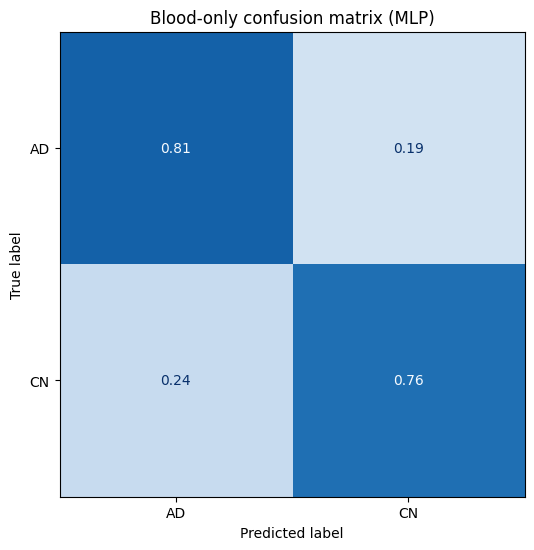

In [40]:
plot_average_confusion_matrix(
    blood_mlp["confusion"],
    ["AD", "CN"],
    "Blood-only confusion matrix (MLP)",
    png=f"{PLOTS}/Blood-only confusion matrix (MLP)"
)

In [41]:
clinical_mlp_model = run_mlp(clinical_only, num_iters=20, pkl=f"{MODELS}/Clinical Only MLP.pkl")

In [42]:
clinical_mlp = evaluate_mlp(f"{MODELS}/Clinical Only MLP.pkl")

Average micro-F1 score: 0.9686649659863944
Average confusion matrix:
[[ 936.6   35.6]
 [  38.1 1341.7]]


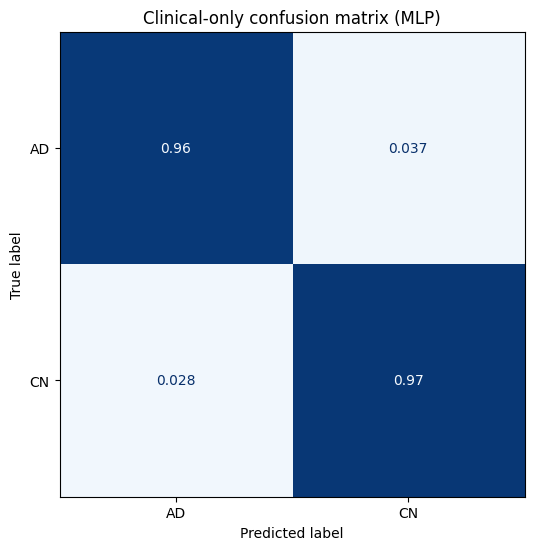

In [43]:
plot_average_confusion_matrix(
    clinical_mlp["confusion"],
    ["AD", "CN"],
    "Clinical-only confusion matrix (MLP)",
    png=f"{PLOTS}/Clinical-only confusion matrix (MLP)"
)

In [44]:
combined_mlp_model = run_mlp(combined, num_iters=20, pkl=f"{MODELS}/Combined MLP.pkl")

In [45]:
combined_mlp = evaluate_mlp(f"{MODELS}/Combined MLP.pkl")

Average micro-F1 score: 0.8806722689075632
Average confusion matrix:
[[51.7  8.5]
 [ 5.7 53.1]]


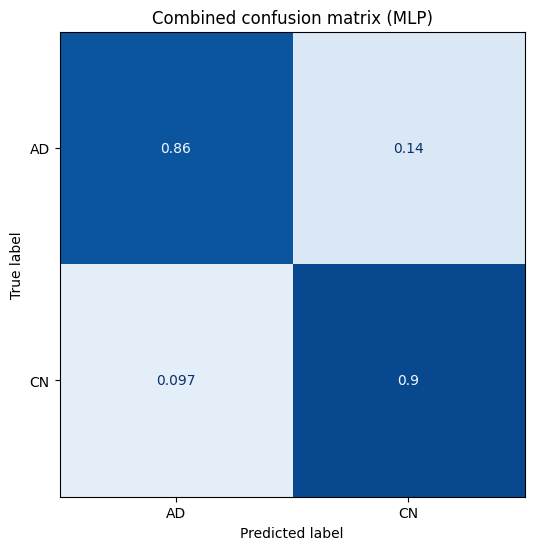

In [46]:
plot_average_confusion_matrix(
    combined_mlp["confusion"],
    ["AD", "CN"],
    "Combined confusion matrix (MLP)",
    png=f"{PLOTS}/Combined confusion matrix (MLP)"
)

## Run MLP on the features selected by MRMR

In [47]:
blood_mlp_mrmr_model = run_mlp(blood_only_subset, num_iters=20, pkl=f"{MODELS}/Blood Only MLP with MRMR.pkl")

In [48]:
blood_mlp_mrmr = evaluate_mlp(f"{MODELS}/Blood Only MLP with MRMR.pkl")

Average micro-F1 score: 0.7983193277310926
Average confusion matrix:
[[48.1 12.4]
 [11.6 46.9]]


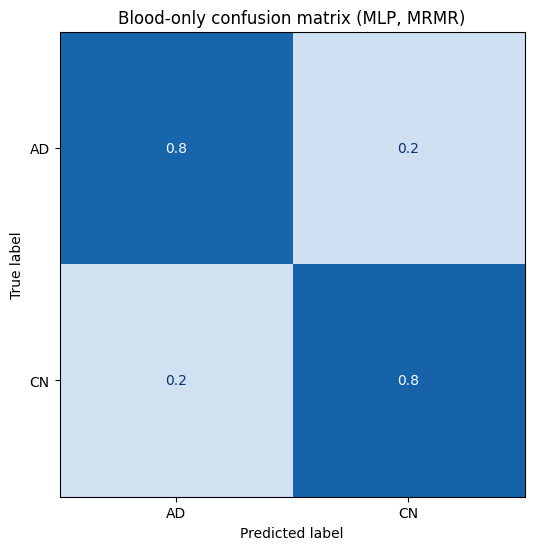

In [49]:
plot_average_confusion_matrix(
    blood_mlp_mrmr["confusion"],
    ["AD", "CN"],
    "Blood-only confusion matrix (MLP, MRMR)",
    png=f"{PLOTS}/Blood-only confusion matrix (MLP, MRMR)"
)

In [50]:
clinical_mlp_mrmr_model = run_mlp(clinical_only_subset, num_iters=20, pkl=f"{MODELS}/Clinical Only MLP with MRMR.pkl")

In [51]:
clinical_mlp_mrmr = evaluate_mlp(f"{MODELS}/Clinical Only MLP with MRMR.pkl")

Average micro-F1 score: 0.9593962585034012
Average confusion matrix:
[[ 924.95   51.15]
 [  44.35 1331.55]]


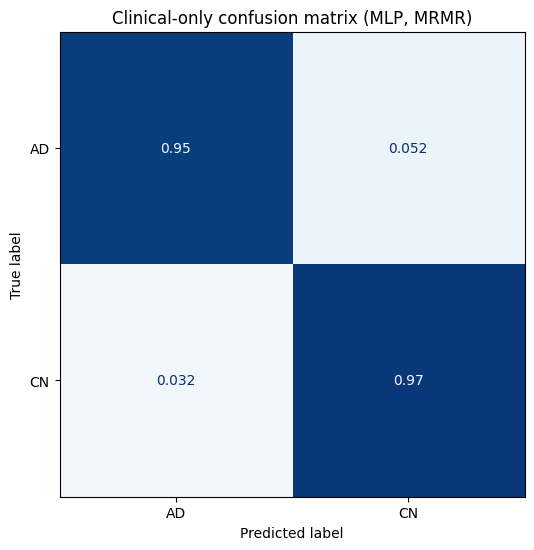

In [52]:
plot_average_confusion_matrix(
    clinical_mlp_mrmr["confusion"],
    ["AD", "CN"],
    "Clinical-only confusion matrix (MLP, MRMR)",
    png=f"{PLOTS}/Clinical-only confusion matrix (MLP, MRMR)"
)

In [53]:
combined_mlp_mrmr_model = run_mlp(combined_subset, num_iters=20, pkl=f"{MODELS}/Combined MLP with MRMR.pkl")

In [54]:
combined_mlp_mrmr = evaluate_mlp(f"{MODELS}/Combined MLP with MRMR.pkl")

Average micro-F1 score: 0.942436974789916
Average confusion matrix:
[[55.65  3.55]
 [ 3.3  56.5 ]]


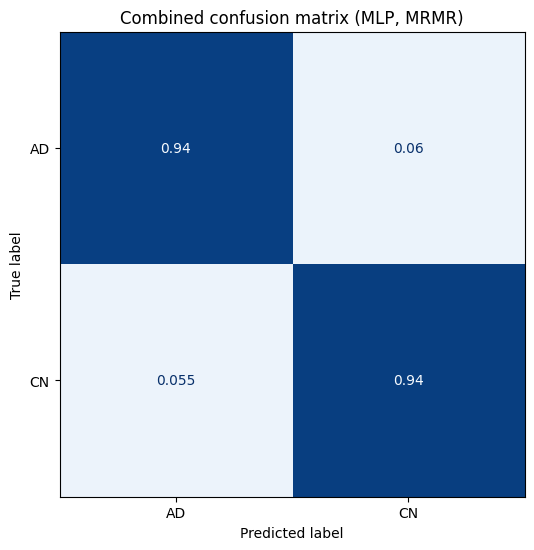

In [55]:
plot_average_confusion_matrix(
    combined_mlp_mrmr["confusion"],
    ["AD", "CN"],
    "Combined confusion matrix (MLP, MRMR)",
    png=f"{PLOTS}/Combined confusion matrix (MLP, MRMR)"
)

## Store the model results

In [56]:
model_results = {
    "blood_lr": blood_lr,
    "clinical_lr": clinical_lr,
    "combined_lr": combined_lr,
    "blood_lr_mrmr": blood_lr_mrmr,
    "clinical_lr_mrmr": clinical_lr_mrmr,
    "combined_lr_mrmr": combined_lr_mrmr,
    "blood_rf": blood_rf,
    "clinical_rf": clinical_rf,
    "combined_rf": combined_rf,
    "blood_mlp": blood_mlp,
    "clinical_mlp": clinical_mlp_mrmr,
    "combined_mlp": combined_mlp,
    "blood_mlp_mrmr": blood_mlp_mrmr,
    "clinical_mlp_mrmr": clinical_mlp_mrmr,
    "combined_mlp_mrmr": combined_mlp_mrmr,
}

with open(f"{MODELS}/Model Results.pkl", "wb") as handle:
    pickle.dump(model_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Read in the cached model results

In [57]:
with open(f"{MODELS}/Model Results.pkl", "rb") as handle:
    model_results = pickle.load(handle)

## Compare models

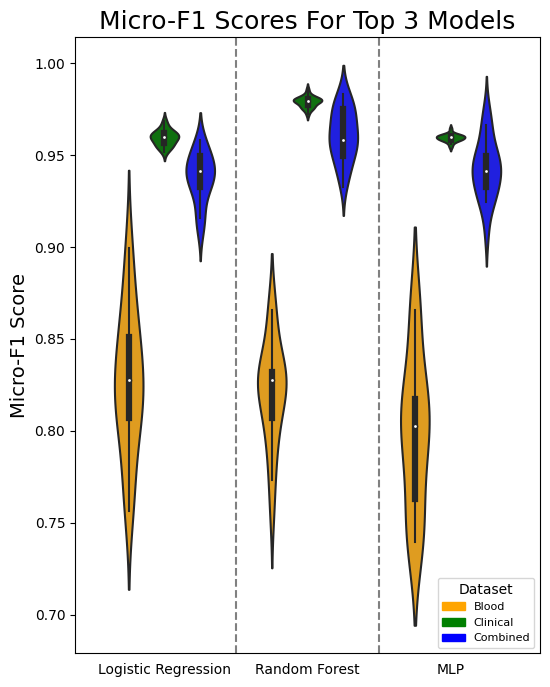

In [58]:
plot_f1_scores(
    [
        model_results["blood_lr_mrmr"]["f1"],
        model_results["clinical_lr_mrmr"]["f1"],
        model_results["combined_lr_mrmr"]["f1"],
        model_results["blood_rf"]["f1"],
        model_results["clinical_rf"]["f1"],
        model_results["combined_rf"]["f1"],
        model_results["blood_mlp_mrmr"]["f1"],
        model_results["clinical_mlp_mrmr"]["f1"],
        model_results["combined_mlp_mrmr"]["f1"],
    ],
    title="Micro-F1 Scores For Top 3 Models",
    ylabel="Micro-F1 Score",
    models=["Logistic Regression", "Random Forest", "MLP"],
    pad=3,
    png=f"{PLOTS}/Micro-F1 Score Comparisons"
)

## Plot feature importance scores from MRMR and random forest

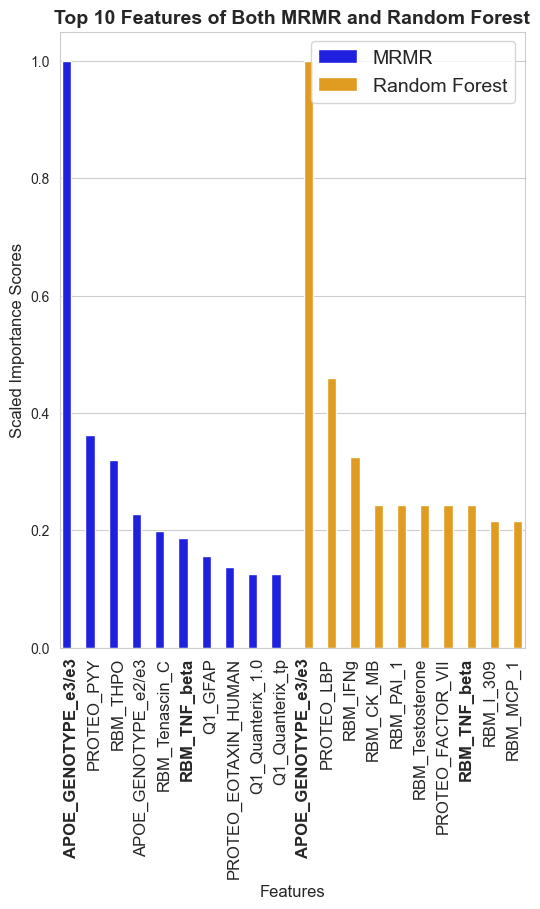

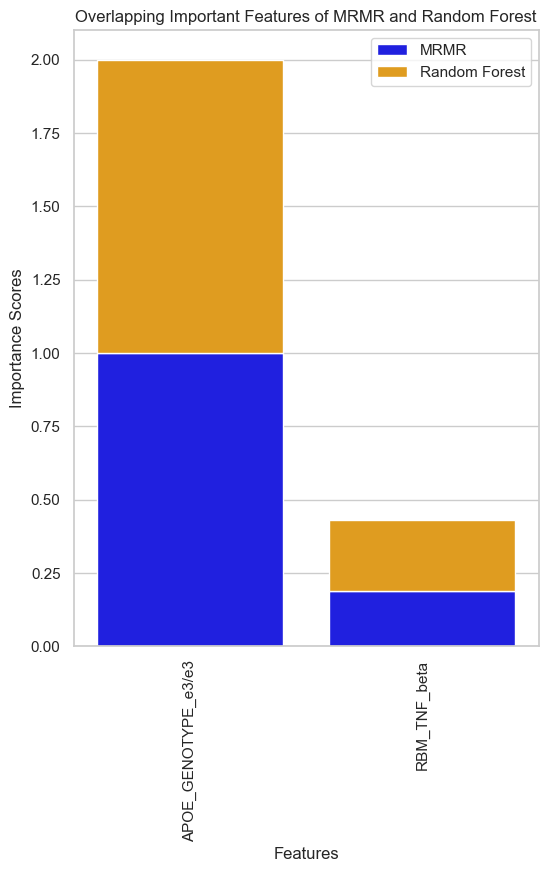

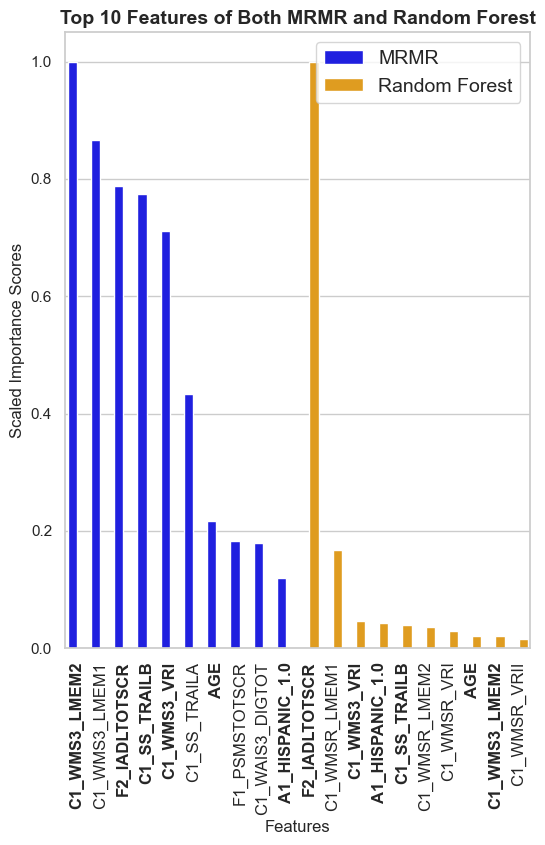

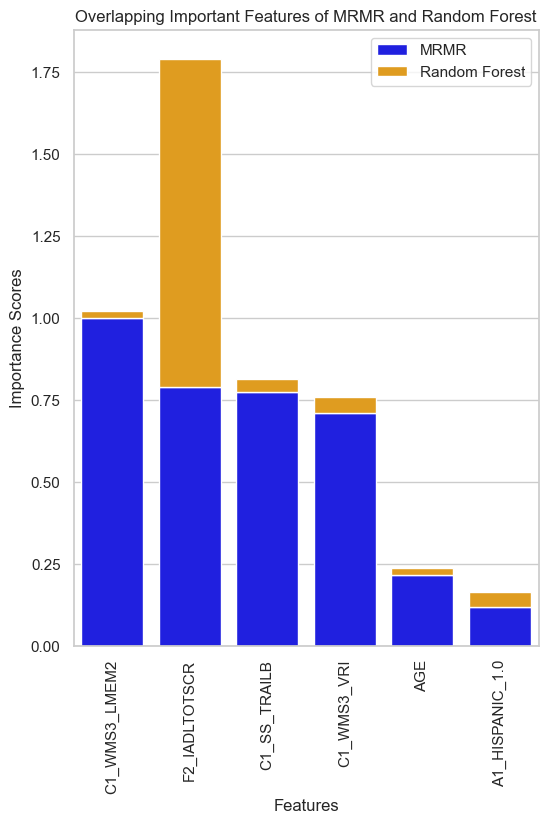

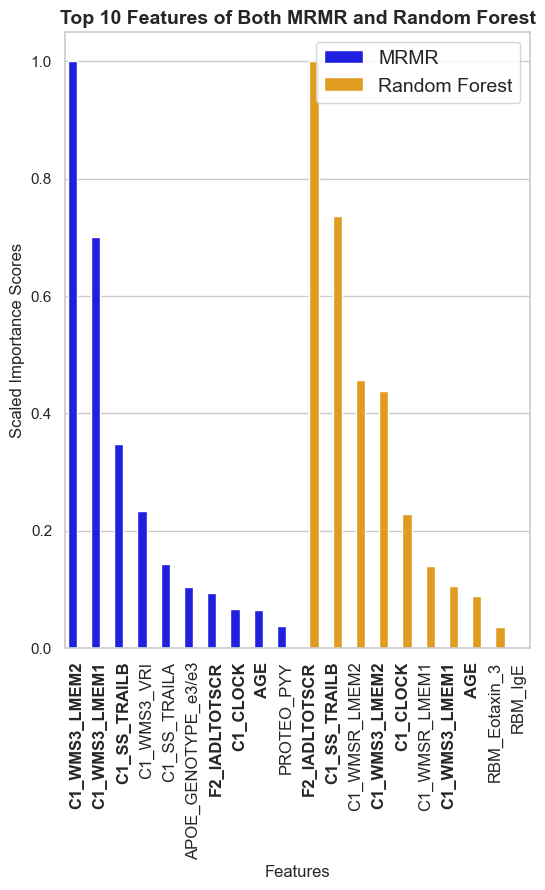

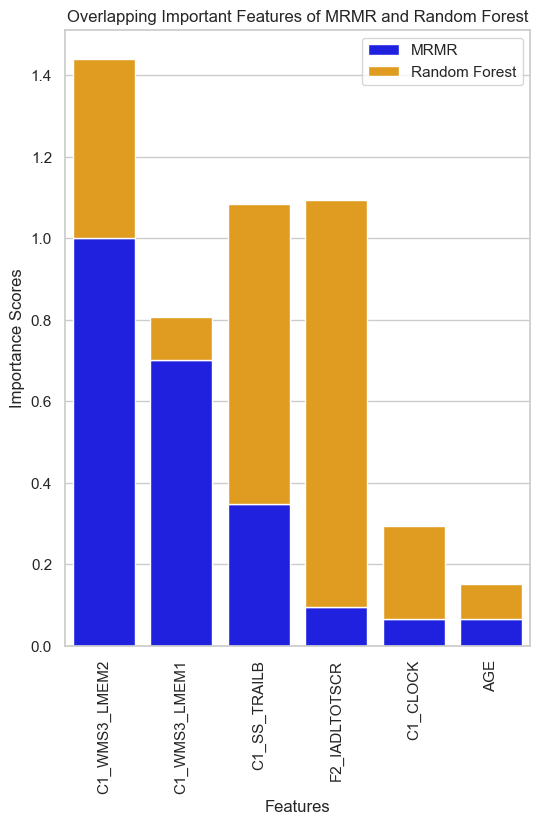

In [59]:
blood_rf_scores, blood_rf_features = model_results["blood_rf"]["importance"], model_results["blood_rf"]["features"]
clinical_rf_scores, clinical_rf_features = model_results["clinical_rf"]["importance"], model_results["clinical_rf"]["features"]
combined_rf_scores, combined_rf_features = model_results["combined_rf"]["importance"], model_results["combined_rf"]["features"]

plot_mrmr_and_rf(blood_mrmr_scores, blood_rf_scores, blood_rf_features)
plot_mrmr_and_rf(clinical_mrmr_scores, clinical_rf_scores, clinical_rf_features)
plot_mrmr_and_rf(combined_mrmr_scores, combined_rf_scores, combined_rf_features)

## Run the same steps on the clinical data containing MCI patients

In [60]:
clinical_lr_mci_mrmr_model = run_logistic_regression(clinical_only_subset_mci, num_iters=20, pkl=f"{MODELS}/Clinical LR with MCI and MRMR.pkl")

In [61]:
clinical_lr_mci_mrmr = evaluate_logistic_regression(f"{MODELS}/Clinical LR with MCI and MRMR.pkl")

Average micro-F1 score: 0.8048309178743962
Average confusion matrix:
[[ 874.95   47.4    54.15]
 [  17.2  1273.95   89.95]
 [  78.8   278.1   183.5 ]]


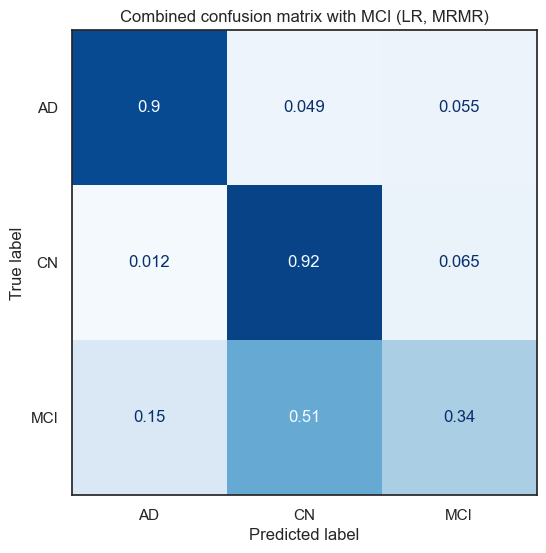

In [62]:
plot_average_confusion_matrix(
    clinical_lr_mci_mrmr["confusion"],
    ["AD", "CN", "MCI"],
    "Combined confusion matrix with MCI (LR, MRMR)",
    png=f"{PLOTS}/Combined confusion matrix with MCI (LR, MRMR)"
)

In [63]:
clinical_rf_mci_model = run_random_forest(clinical_only_mci, num_iters=20, pkl=f"{MODELS}/Clinical RF with MCI.pkl")

In [64]:
clinical_rf_mci = evaluate_random_forest(f"{MODELS}/Clinical RF with MCI.pkl")

Average micro-F1 score: 0.8584368530020701
Average confusion matrix:
[[ 918.85   19.05   35.1 ]
 [  12.05 1313.15   52.45]
 [  75.8   215.8   255.75]]


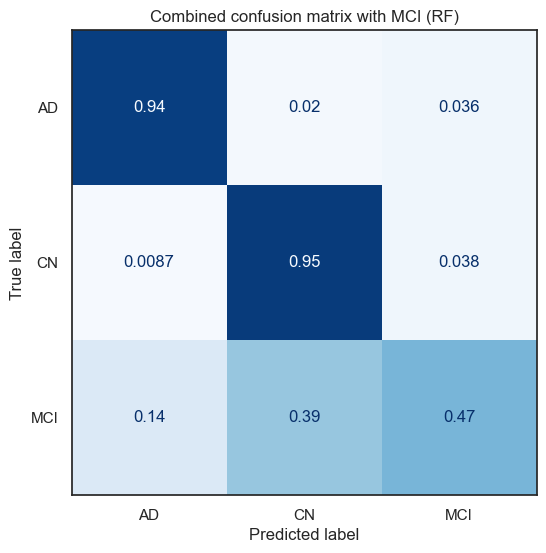

In [65]:
plot_average_confusion_matrix(
    clinical_rf_mci["confusion"],
    ["AD", "CN", "MCI"],
    "Combined confusion matrix with MCI (RF)",
    png=f"{PLOTS}/Combined confusion matrix with MCI (RF)"
)

In [66]:
clinical_mlp_mci_mrmr_model = run_mlp(clinical_only_subset_mci, num_iters=20, pkl=f"{MODELS}/Clinical MLP with MCI and MRMR.pkl")

In [67]:
clinical_mlp_mci_mrmr = evaluate_mlp(f"{MODELS}/Clinical MLP with MCI and MRMR.pkl")

Average micro-F1 score: 0.8112146307798482
Average confusion matrix:
[[ 871.     26.4    79.05]
 [  17.2  1222.85  134.35]
 [  75.45  214.65  257.05]]


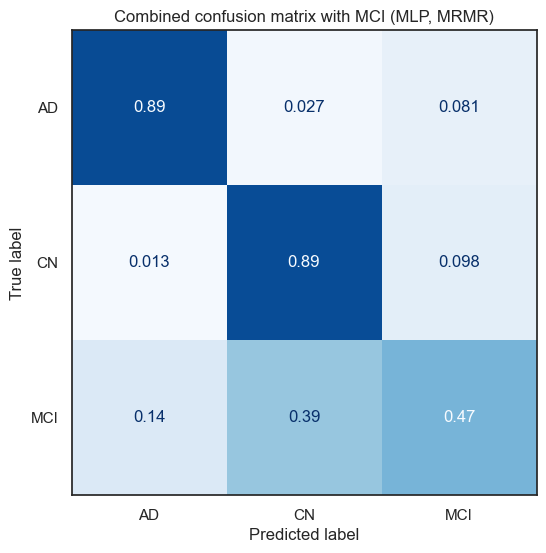

In [68]:
plot_average_confusion_matrix(
    clinical_mlp_mci_mrmr["confusion"],
    ["AD", "CN", "MCI"],
    "Combined confusion matrix with MCI (MLP, MRMR)",
    png=f"{PLOTS}/Combined confusion matrix with MCI (MLP, MRMR)"
)

In [69]:
mci_model_results = {
    "lr_mci_mrmr": clinical_lr_mci_mrmr,
    "rf_mci": clinical_rf_mci,
    "mlp_mci_mrmr": clinical_mlp_mci_mrmr,
}

with open(f"{MODELS}/MCI Model Results.pkl", "wb") as handle:
    pickle.dump(mci_model_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
with open(f"{MODELS}/MCI Model Results.pkl", "rb") as handle:
    mci_model_results = pickle.load(handle)

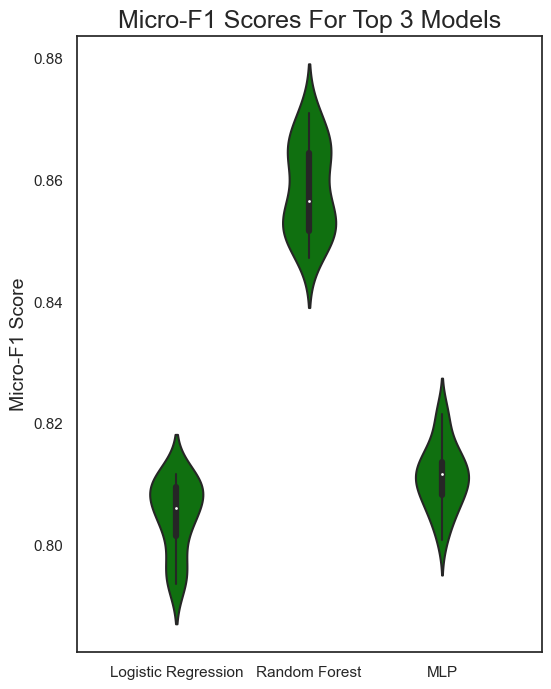

In [71]:
plot_mci_f1_scores(
    [
        mci_model_results["lr_mci_mrmr"]["f1"],
        mci_model_results["rf_mci"]["f1"],
        mci_model_results["mlp_mci_mrmr"]["f1"]
    ],
    title="Micro-F1 Scores For Top 3 Models",
    ylabel="Micro-F1 Score",
    models=["Logistic Regression", "Random Forest", "MLP"],
    pad=1
)

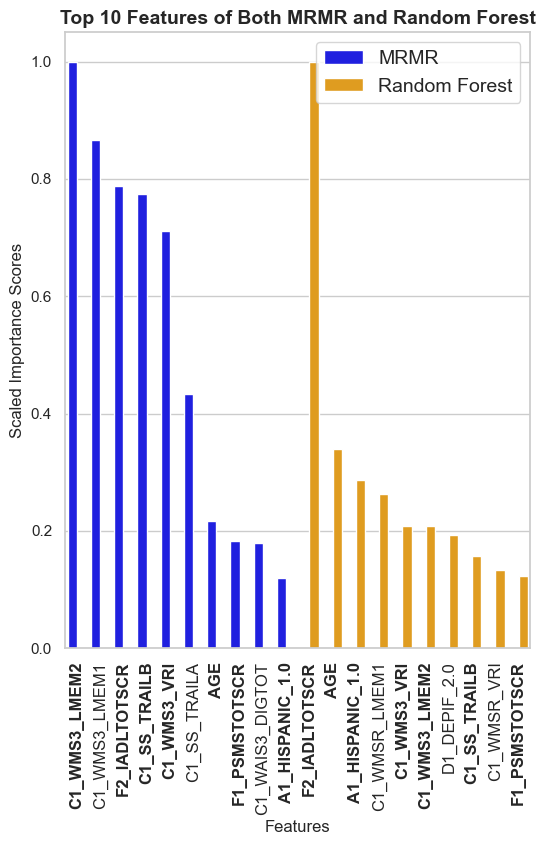

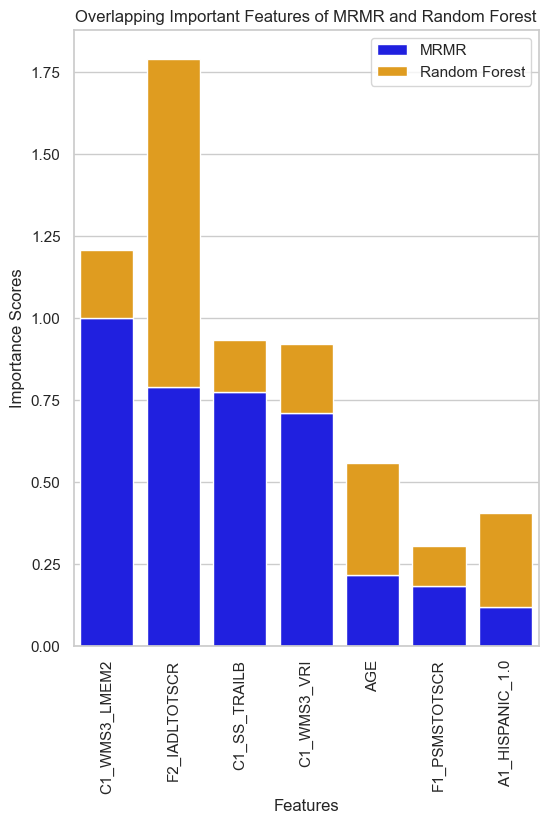

In [72]:
clinical_rf_scores, clinical_rf_features = mci_model_results["rf_mci"]["importance"], mci_model_results["rf_mci"]["features"]
plot_mrmr_and_rf(clinical_mrmr_scores, clinical_rf_scores, clinical_rf_features)